<div>
<img src="poly_coeff_matrix.jpg"/>
</div>

https://muthu.co/maths-behind-polynomial-regression/ (link for article above)

In [20]:
#actual model class code. I will comment this in a later commit, but it should be fairly self explanatory.
import numpy as np
import matplotlib.pyplot as plt

class BadInputError(Exception):
    def __init__(self, message="Bad input error"):
        self.message = message
        super().__init__(self.message)

class PolyFitter:
    def __init__(self, m=15):
        self._im = m
        self._X_train = []
        self._Y_train = []
        self._X_test = []
        self._Y_test = []
    
    def split_train_test(self, X, Y, train_ratio=.8):
        try:
            if (len(X) != len(Y)):
                raise BadInputError("dependent and independent variable lengths do not match")
        except BadInputError as err:
            print(err)
        
        size = int(len(X) * train_ratio)
        
        temp = np.random.choice(len(X), len(X), replace=False)
    
        indices, indices1 = temp[:size], temp[size:]
        
        # Assigning train data
        
        self._X_train = X[indices]
        self._Y_train = Y[indices]
        
        indices1 = np.array(indices1)
                
        # Assigning test data
        self._X_test = X[indices1]
        self._Y_test = Y[indices1]
    
        test_sorted_indices = np.argsort(self._X_test)
        train_sorted_indices = np.argsort(self._X_train)

        self._X_test = self._X_test[test_sorted_indices]
        self._X_train = self._X_train[train_sorted_indices]
        
        self._Y_test = self._Y_test[test_sorted_indices]
        self._Y_train = self._Y_train[train_sorted_indices]

        
        return [self._X_train, self._Y_train, self._X_test, self._Y_test]
    
    def making_A(self, m, x):
        x = np.array(x)
        data = x
        L = np.zeros((m+1,m+1))
        for i in range(2*m, m-1, -1):
            c = 0
            for j in range(i, i-m-1, -1):
                L[2 * m - i, c] = np.sum(data ** j)
                c += 1
            
        return L

    def making_B(self,m,y,x):
        y = np.array(y)
        x = np.array(x)
        data=x
        L = np.zeros((m+1,1))
        for i in range(m, -1,-1):
            L[m-i] = np.sum(y*(data**i))

        return L

    def solve_polyfit(self, A,B,m):
        coeffs = np.zeros((m,1))
        coeffs = np.linalg.solve(A,B)
        coeffs = np.flip(coeffs)
        return coeffs

    def check(self, coeffs, X):
        def PolyCoefficients(x, coeffs):
            o = len(coeffs)
            y = 0
            for i in range(o):
                y += coeffs[i][0]*x**i
            return y
        e = np.zeros(len(X))
        for i in range(len(X)):
            for j in range(len(coeffs)):
                e[i] += X[i]**j * coeffs[j][0]
                
        return PolyCoefficients(X, coeffs)

    def rmse(self, coeffs, Xt, Yt):
        e = np.zeros(len(Xt))
        for i in range(len(Xt)):
            for j in range(len(coeffs)):
                e[i] += Xt[i]**j * coeffs[j]

        test = Yt
        err = test - e
        rmserr = ((np.sum(err**2)/len(err)))**(1/2)
        return rmserr
    
    def make_graphs(self, X, Y, model_out, rmserr, m):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))

        model_out_sorted = model_out
        axes[0].scatter(X, Y)
        axes[0].set_title("data")
        axes[0].axhline(0, color='black', linewidth=0.5)
        axes[0].axvline(0, color='black', linewidth=0.5)

        axes[1].plot(X, model_out)
        axes[1].set_title("model output")
        axes[1].axhline(0, color='black', linewidth=0.5)
        axes[1].axvline(0, color='black', linewidth=0.5)

        axes[2].scatter(X, Y, color='green', label='data')
        axes[2].plot(X, model_out, color='blue', label='model')
        axes[2].set_title("Comparison")
        axes[2].legend()
        axes[2].axhline(0, color='black', linewidth=0.5)
        axes[2].axvline(0, color='black', linewidth=0.5)

        axes[3].scatter(model_out, abs(Y - model_out), color="red")
        axes[3].set_title("Residual")
        axes[3].axhline(0, color='black', linewidth=0.5)
        axes[3].axvline(0, color='black', linewidth=0.5)

        fig.suptitle(f'For m = {m}, rmserr = {rmserr}')

        plt.tight_layout()
        plt.show()

        
    
    def fit_model(self, X = None, Y = None, limit=15, print_graphs=False):
        if (X == None):
            X = self._X_train
        if (Y == None):
            Y = self._Y_train
        try:
            if (X == []) or (Y == []):
                raise BadInputError("No data was provided to the model")
        
        except BadInputError as err:
            print(err)
        
        mn = None
        model = None
        for m in range(0, limit):
            coeffs = self.solve_polyfit(self.making_A(m,X), self.making_B(m,Y,X),m)
            model_out = self.check(coeffs, X)
            rmserr = self.rmse(coeffs, self._X_test, self._Y_test)

            if (mn == None):
                mn = rmserr
                model = coeffs

            if (rmserr < mn):
                mn = rmserr
                model = coeffs

            if (print_graphs):
                self.make_graphs(X, Y, model_out, rmserr, m)
                

        return [mn, model, len(model)]


In [13]:
# You can add your own dataset here, this was a synthetic one for development purposes
X = np.linspace(-3,2.5,400)

Y = X**6+2*X**5-8*X**4-14*X**3+11*X**2+28*X+12

noise = np.random.randn(*Y.shape)
Y = Y + 5*noise

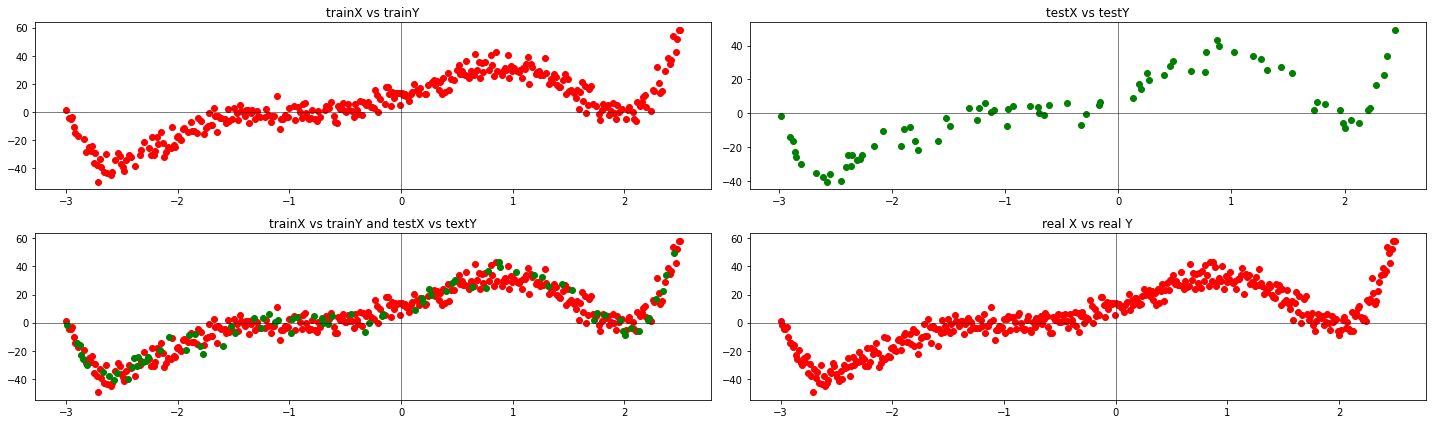

In [14]:
PF = PolyFitter(m = 15)
o = PF.split_train_test(X, Y)   # testing the split train test
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,6))

axes[0][0].scatter(o[0], o[1], color='red')
axes[0][0].axhline(0, color='black', linewidth=0.5)
axes[0][0].axvline(0, color='black', linewidth=0.5)
axes[0][0].set_title("trainX vs trainY")

axes[0][1].scatter(o[2],o[3], color='green')
axes[0][1].axhline(0, color='black', linewidth=0.5)
axes[0][1].axvline(0, color='black', linewidth=0.5)
axes[0][1].set_title("testX vs testY")

axes[1][0].scatter(o[0], o[1], color='red')
axes[1][0].scatter(o[2],o[3], color='green')
axes[1][0].axhline(0, color='black', linewidth=0.5)
axes[1][0].axvline(0, color='black', linewidth=0.5)
axes[1][0].set_title("trainX vs trainY and testX vs textY")

axes[1][1].scatter(X, Y, color='red')
axes[1][1].axhline(0, color='black', linewidth=0.5)
axes[1][1].axvline(0, color='black', linewidth=0.5)
axes[1][1].set_title("real X vs real Y")

plt.tight_layout()
plt.plot()
x = 1

C:\Users\sidha\AppData\Local\Temp\ipykernel_22120\413327282.py:145: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (X == []) or (Y == []):


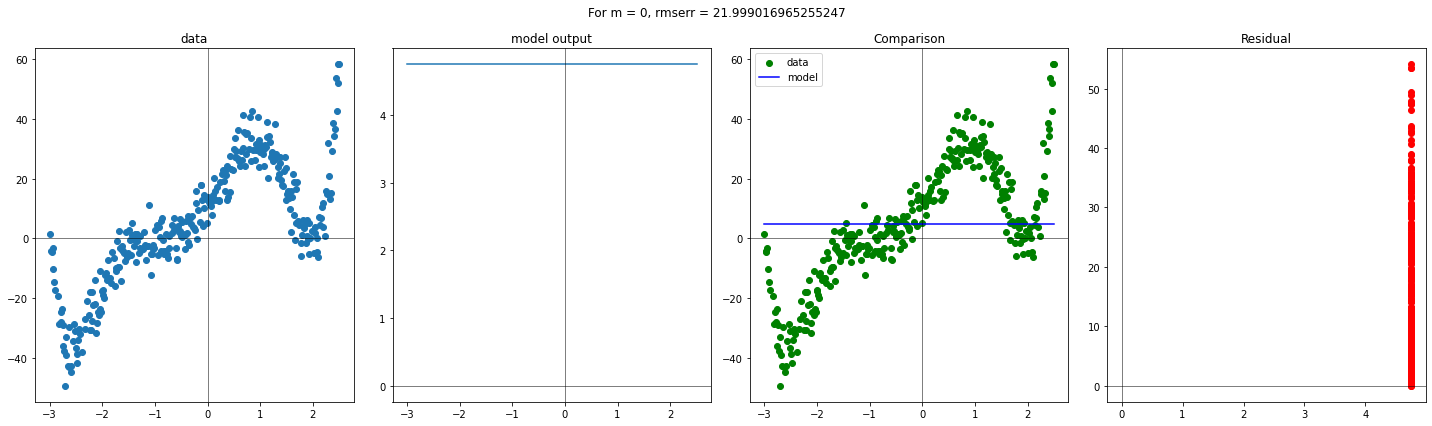

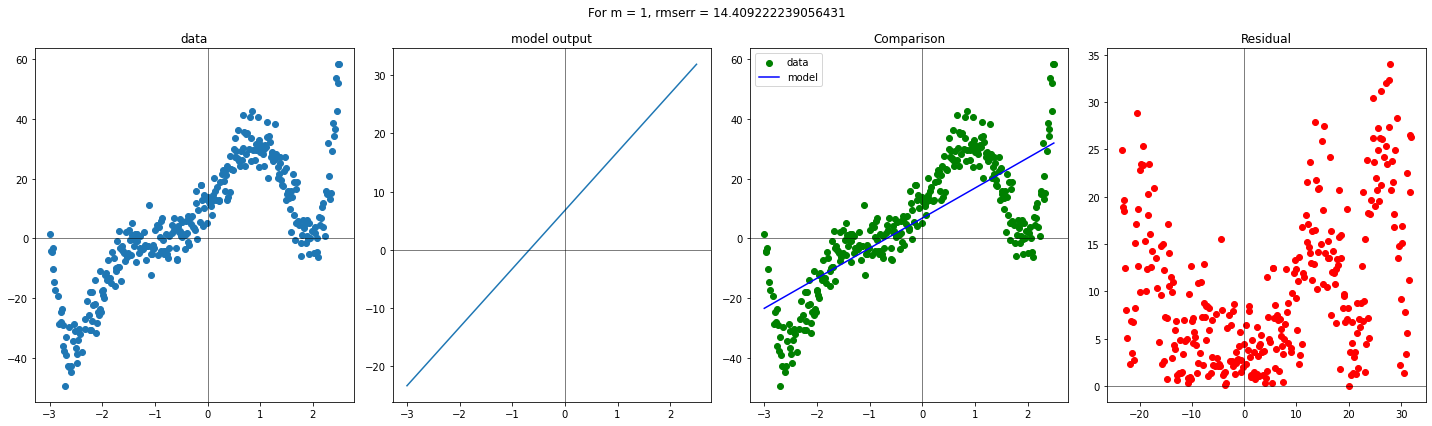

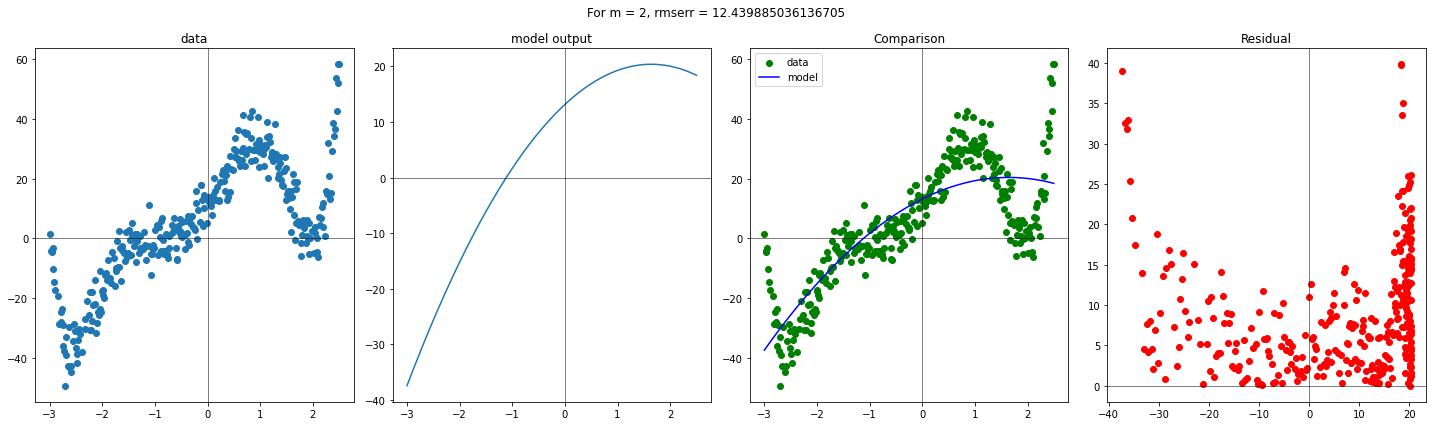

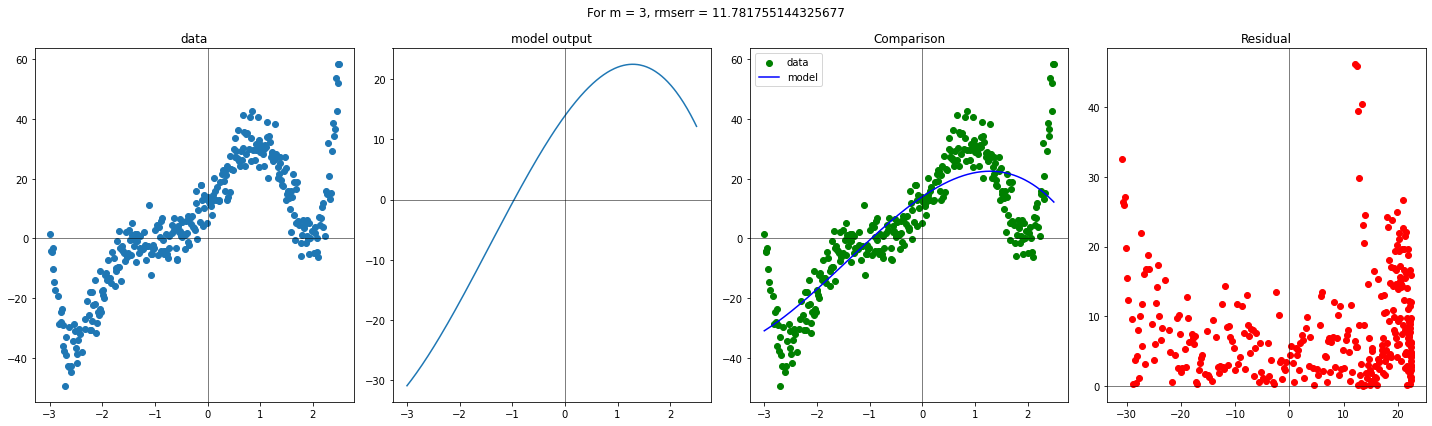

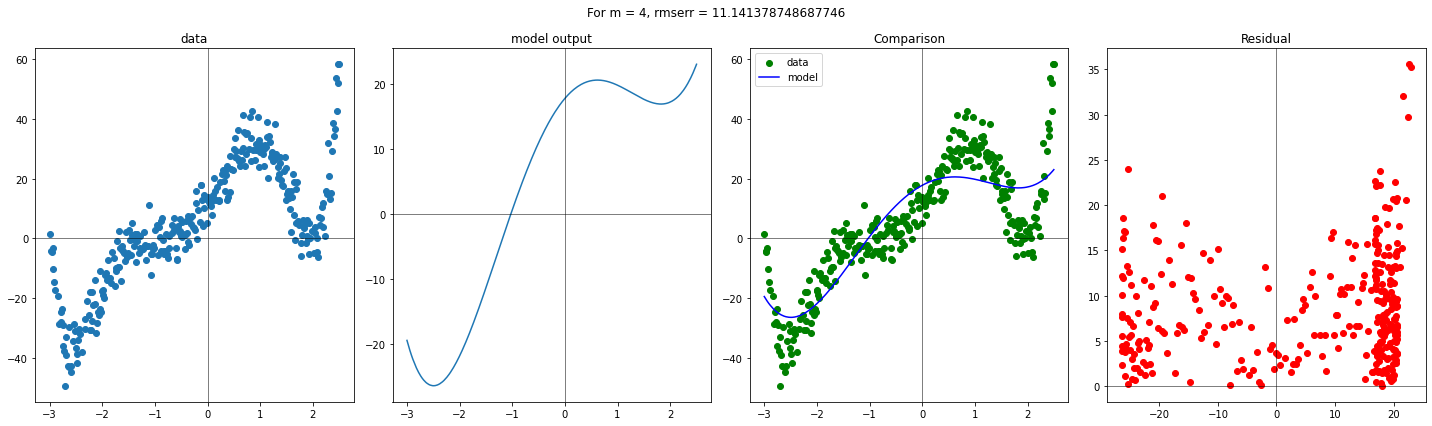

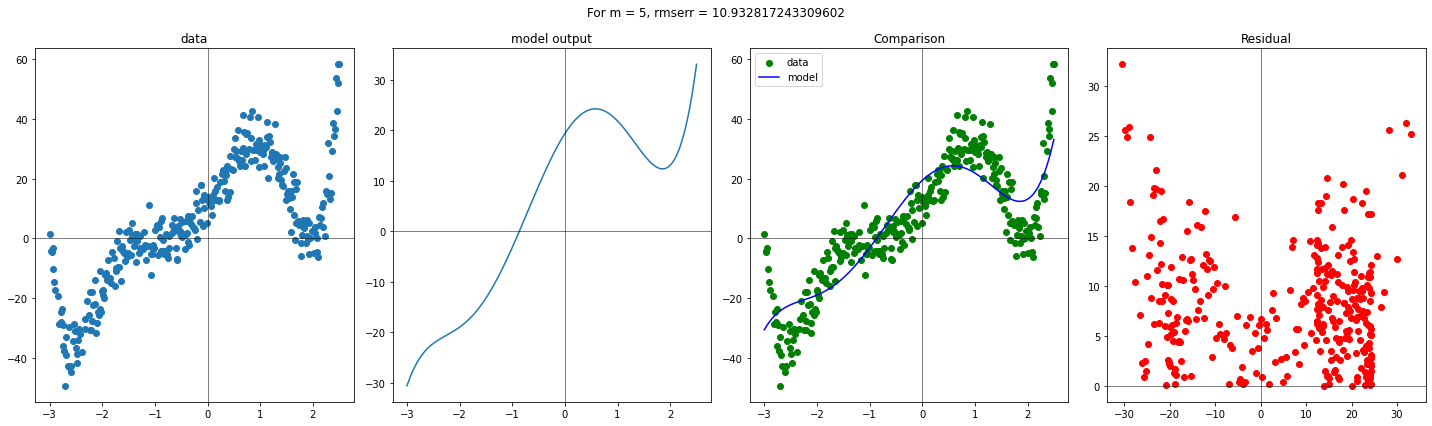

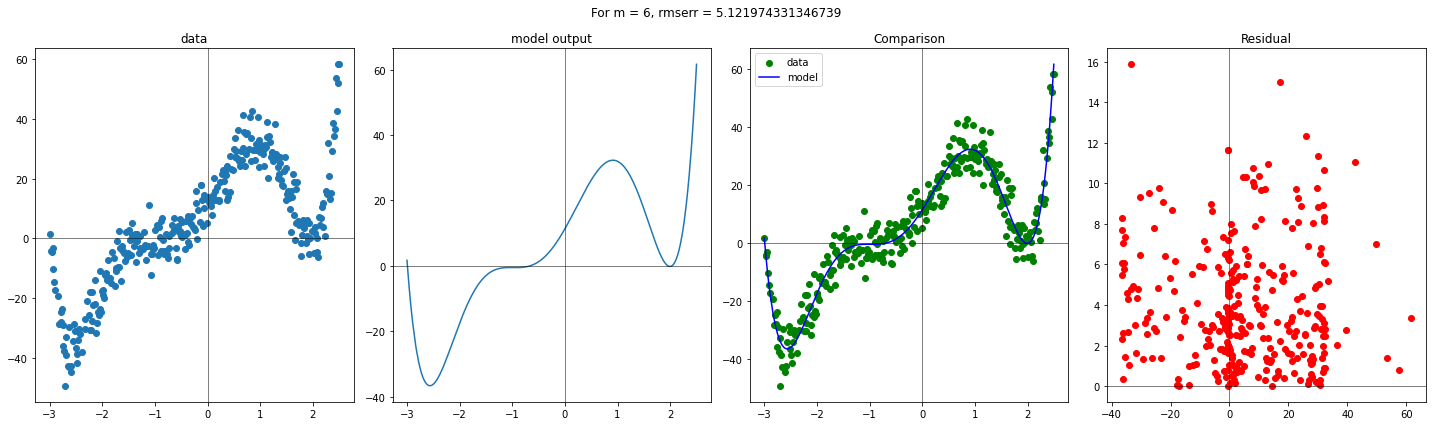

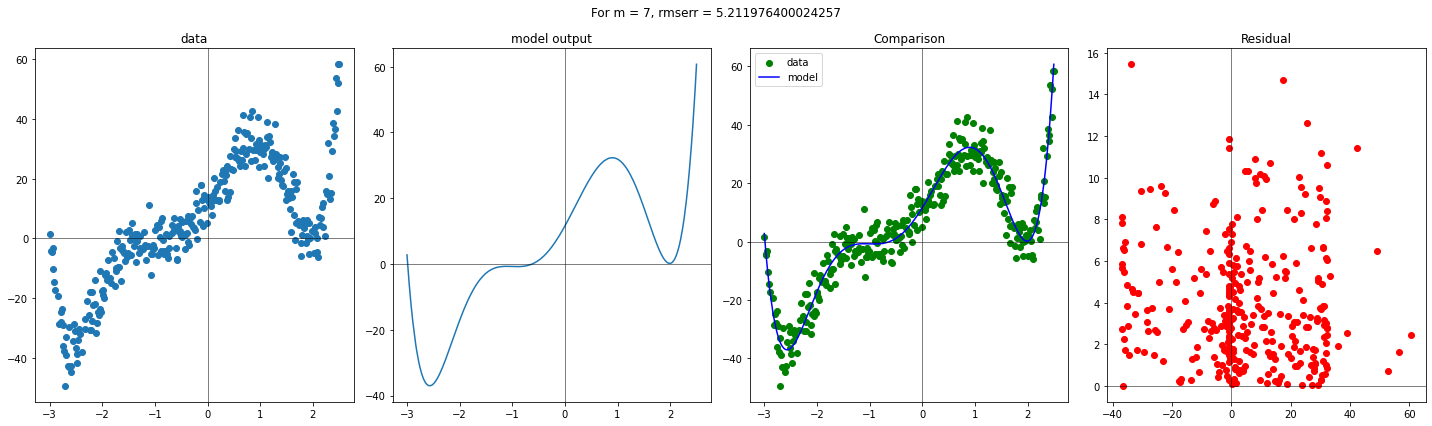

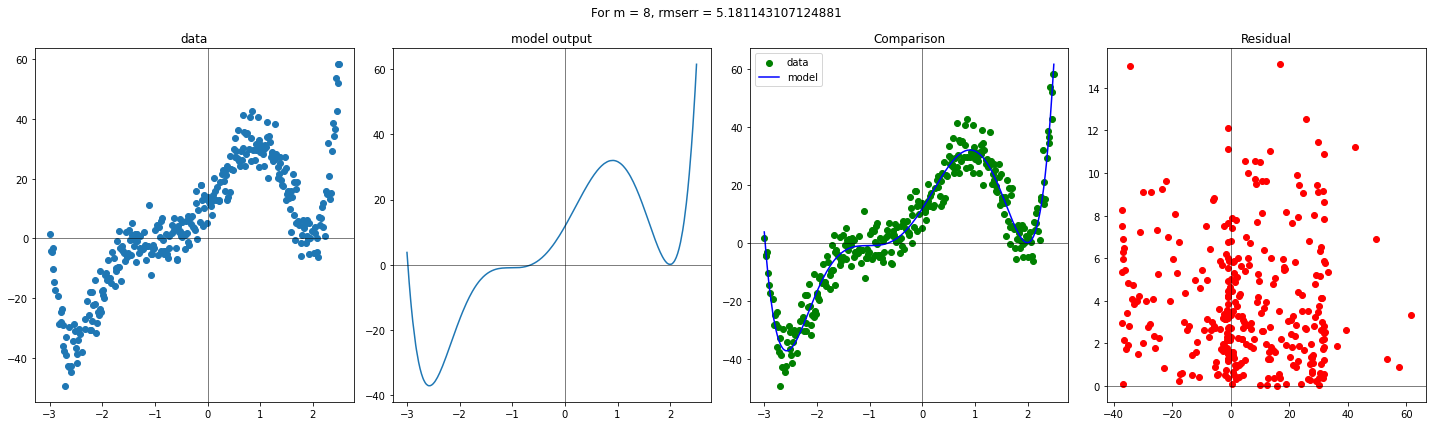

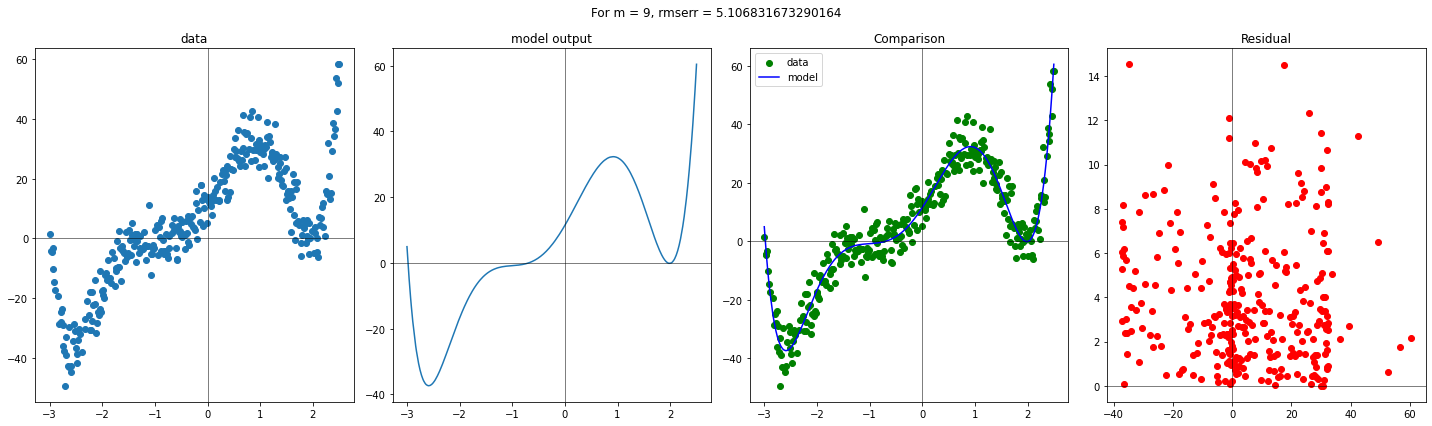

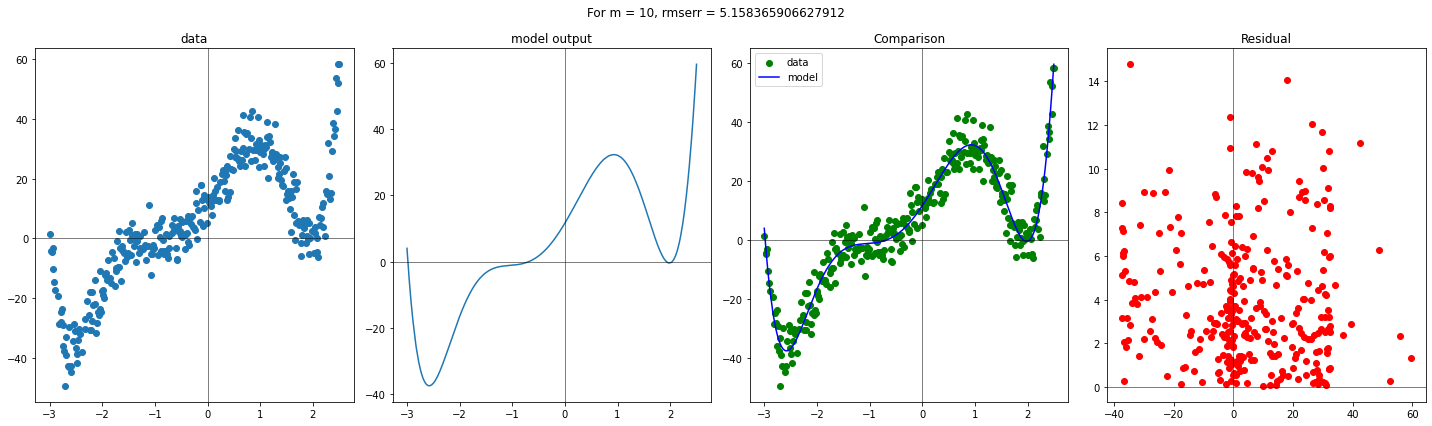

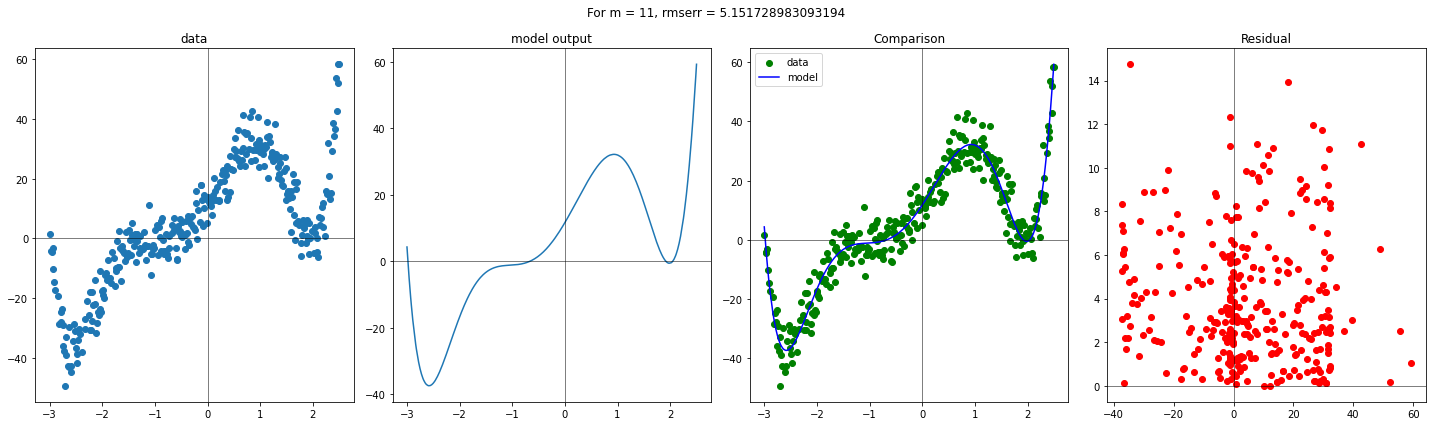

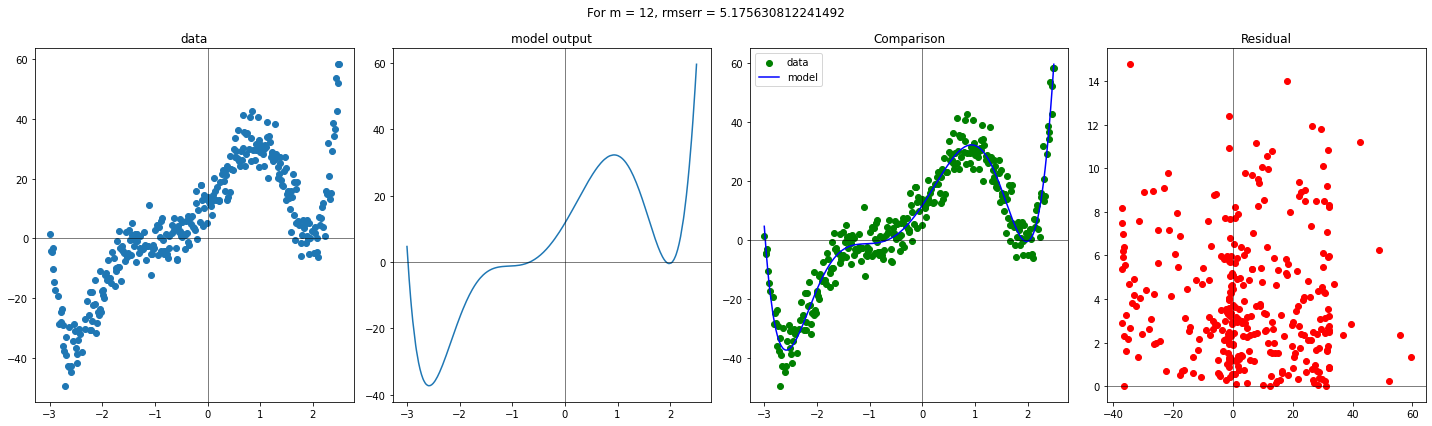

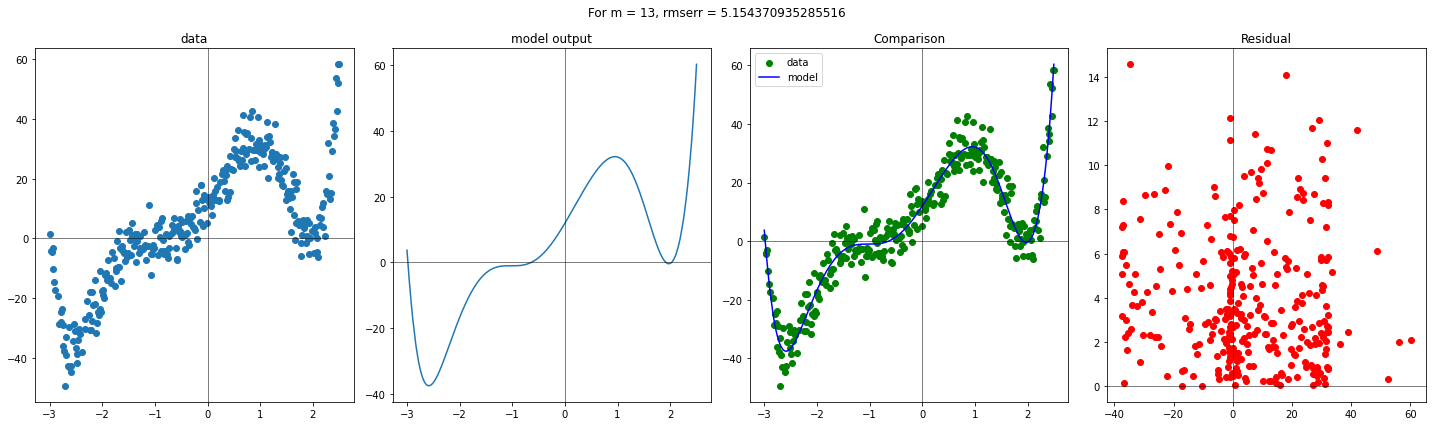

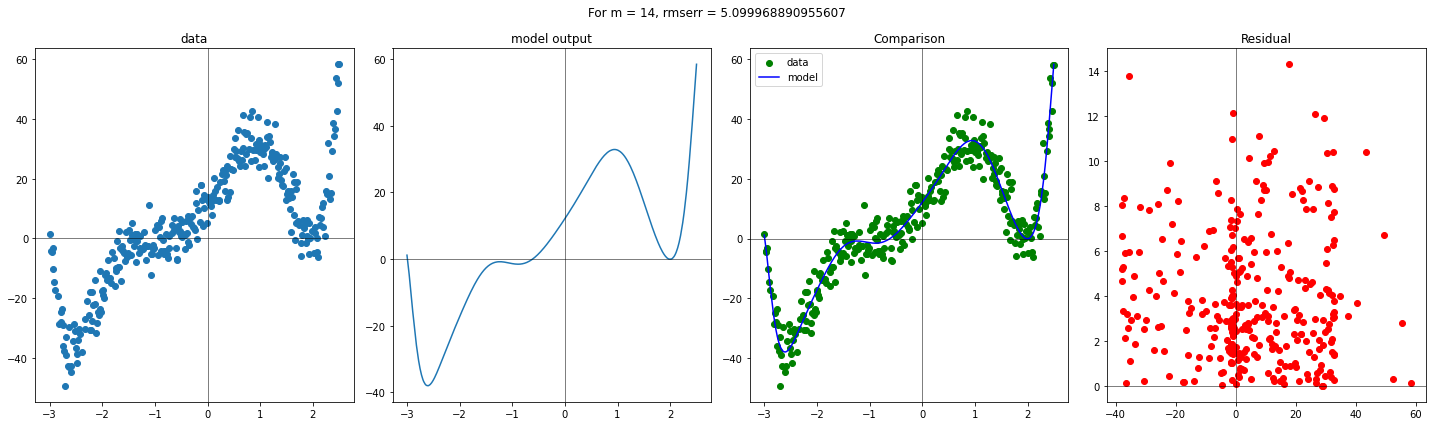

[5.099968890955607,
 array([[ 1.20895254e+01],
        [ 2.40287216e+01],
        [ 4.34775247e+00],
        [ 2.28761305e+00],
        [ 5.68025592e+00],
        [-1.66454273e+01],
        [-1.01321395e+01],
        [ 9.47737236e+00],
        [ 4.51407488e+00],
        [-2.40513805e+00],
        [-9.81095100e-01],
        [ 2.98584957e-01],
        [ 1.09905411e-01],
        [-1.44377715e-02],
        [-4.98970592e-03]]),
 15]

In [19]:
mod = PF.fit_model(print_graphs=True)  # output is [rmse of model, model parameters, number of hyperparameters/degree of polynomial]
mod

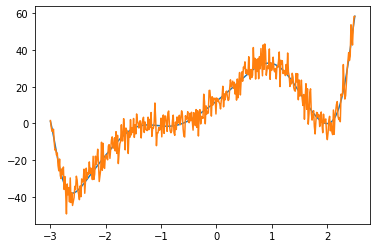

In [17]:
plt.plot(X, PF.check(mod[1], X))
plt.plot(X, Y)